In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import open3d as o3d
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split

In [4]:
torch.cuda.is_available()

True

# The Model

In [5]:
class PointCloudAutoEncoder(nn.Module):
    def __init__(self, input_dim=3, bottleneck_size=128, num_points=1024):
        super(PointCloudAutoEncoder, self).__init__()
        self.num_points = num_points

        # Encoder: Maps input point cloud to a latent representation
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(256, bottleneck_size, kernel_size=3),
            nn.AdaptiveMaxPool1d(1)
        )

        # Decoder: Maps latent representation back to point cloud
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_points * input_dim),
        )

    def forward(self, x):
        # x: [batch_size, num_points, input_dim]
        
        # Encoder
        x = x.permute(0, 2, 1)  # Change to [batch_size, input_dim, num_points]
        latent = self.encoder(x)  # [batch_size, bottleneck_size, 1]
        latent = latent.view(latent.size(0), -1)  # [batch_size, bottleneck_size]

        # Decoder
        reconstructed = self.decoder(latent)  # [batch_size, num_points * input_dim]
        reconstructed = reconstructed.view(-1, self.num_points, 3)  # [batch_size, num_points, input_dim]
        
        return reconstructed

In [6]:
#
# LOSS METHODS
#

from torch.nn import MSELoss

def chamfer_loss(pred, target):
    """
    Computes the Chamfer Distance between two point clouds.
    Args:
        pred: Predicted point cloud [batch_size, num_points, 3]
        target: Ground truth point cloud [batch_size, num_points, 3]
    Returns:
        Chamfer distance (scalar).
    """
    # Compute pairwise distances
    pred_expand = pred.unsqueeze(2)  # [batch_size, num_points, 1, 3]
    target_expand = target.unsqueeze(1)  # [batch_size, 1, num_points, 3]
    dist = torch.norm(pred_expand - target_expand, dim=-1)  # [batch_size, num_points, num_points]

    # Find nearest neighbors
    dist_to_target = torch.min(dist, dim=2)[0]  # Distance from pred to target
    dist_to_pred = torch.min(dist, dim=1)[0]  # Distance from target to pred

    # Average distances
    loss = torch.mean(dist_to_target) + torch.mean(dist_to_pred)
    return loss



"""
COMBINED LOSS
"""
def combined_loss(pred, target):
    return chamfer_loss(pred, target)
    #loss_fn = MSELoss()
    #mse_loss = loss_fn(pred, target)
    #ch_loss = chamfer_loss(pred, target)
    #return (mse_loss + ch_loss) * 0.5
    

# Dataset

In [7]:
def downsample_point_cloud(point_cloud, target_points=1024):
    """
    Uniformly downsamples a point cloud to a fixed number of points.
    Args:
        point_cloud (torch.Tensor): Input point cloud of shape [num_points, 3].
        target_points (int): Desired number of points in the output.
    Returns:
        torch.Tensor: Downsampled point cloud of shape [target_points, 3].
    """
    num_points = point_cloud.shape[0]
    if num_points > target_points:
        indices = torch.randperm(num_points)[:target_points]  # Randomly select indices
        return point_cloud[indices]
    elif num_points < target_points:
        # Upsample by duplicating points
        repeat_factor = (target_points + num_points - 1) // num_points
        extended = point_cloud.repeat(repeat_factor, 1)[:target_points]
        return extended
    return point_cloud

class PointCloudDataset(Dataset):
    def __init__(self, root_dir, split="train", target_points=1024, transform=None):
        """
        Args:
            root_dir (str): Root directory containing subfolders with .ply files.
            split (str): 'train' or 'val'. Determines the file names.
            target_points (int): Number of points to standardize the point clouds to.
            transform (callable, optional): Optional transform to apply to the point clouds.
        """
        self.root_dir = root_dir
        self.split = split
        self.target_points = target_points
        self.transform = transform
        self.samples = []

        # Gather all subfolder paths and corresponding files
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                incomplete_path = os.path.join(subfolder_path, f"{subfolder}h.ply")
                ground_truth_path = os.path.join(subfolder_path, f"{subfolder}.ply")
                if os.path.exists(incomplete_path) and os.path.exists(ground_truth_path):
                    self.samples.append((incomplete_path, ground_truth_path))
                    
        print(f"Created dataset with {len(self.samples)} entries")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the incomplete and ground truth point clouds
        incomplete_path, ground_truth_path = self.samples[idx]

        incomplete_pcd = o3d.io.read_point_cloud(incomplete_path)
        ground_truth_pcd = o3d.io.read_point_cloud(ground_truth_path)

        incomplete_points = torch.tensor(incomplete_pcd.points, dtype=torch.float32)
        ground_truth_points = torch.tensor(ground_truth_pcd.points, dtype=torch.float32)

        # Downsample or upsample to the target number of points
        incomplete_points = downsample_point_cloud(incomplete_points, target_points=self.target_points)
        ground_truth_points = downsample_point_cloud(ground_truth_points, target_points=self.target_points)

        # Apply transformations if any
        if self.transform:
            incomplete_points = self.transform(incomplete_points)
            ground_truth_points = self.transform(ground_truth_points)

        return incomplete_points, ground_truth_points
    
def visualize_point_cloud(tensor_point_cloud):
    """
    Visualizes a point cloud stored as a PyTorch tensor using Open3D.
    Args:
        tensor_point_cloud (torch.Tensor): Point cloud of shape [num_points, 3].
    """
    # Ensure the tensor is detached and converted to a NumPy array
    points = tensor_point_cloud.detach().cpu().numpy()

    # Create an Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])
    
    
def plot_point_cloud(numpy_point_cloud):   
    # Create a 3D scatter plot with matplotlib
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot of the point cloud
    ax.scatter(numpy_point_cloud[:, 2], numpy_point_cloud[:, 1], numpy_point_cloud[:, 2], s=1)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Show the plot
    plt.show()

# Training

In [8]:
def validate_autoencoder(model, dataloader, device='cuda'):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for incomplete_pc, ground_truth_pc in dataloader:
            incomplete_pc = incomplete_pc.to(device)
            ground_truth_pc = ground_truth_pc.to(device)

            # Get the reconstructed point cloud
            reconstructed_pc = model(incomplete_pc)

            # Calculate the loss against the ground truth
            loss = combined_loss(reconstructed_pc, ground_truth_pc)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train_with_ground_truth(model, optimizer, train_loader, val_loader, epochs=50, device='cuda'):
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for incomplete_pc, ground_truth_pc in train_loader:
            incomplete_pc = incomplete_pc.to(device)
            ground_truth_pc = ground_truth_pc.to(device)

            # Reconstruct point cloud
            reconstructed_pc = model(incomplete_pc)

            # Compute loss against ground truth
            loss = combined_loss(reconstructed_pc, ground_truth_pc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = validate_autoencoder(model, val_loader, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
 # Dataset root directory
root_dir = "../../datasets/voxel10000"

# Create dataset and dataloaders
full_dataset = PointCloudDataset(root_dir=root_dir, split="train", target_points=1024)

# Define the split ratio (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


#demo_entry = val_dataset[1]
#visualize_point_cloud(demo_entry)

Created dataset with 0 entries


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [27]:
# Initialize model, optimizer
input_dim = 3
bottleneck_size = 256
num_points = 1024
epochs = 30
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PointCloudAutoEncoder(input_dim=input_dim, bottleneck_size=bottleneck_size, num_points=num_points)

Epoch 1/30, Train Loss: 0.9104, Val Loss: 0.7948
Epoch 2/30, Train Loss: 0.7343, Val Loss: 0.7896
Epoch 3/30, Train Loss: 0.7359, Val Loss: 0.8010
Epoch 4/30, Train Loss: 0.7247, Val Loss: 0.7986
Epoch 5/30, Train Loss: 0.7143, Val Loss: 0.8279
Epoch 6/30, Train Loss: 0.7090, Val Loss: 0.8456
Epoch 7/30, Train Loss: 0.7026, Val Loss: 0.7483
Epoch 8/30, Train Loss: 0.7032, Val Loss: 0.7544
Epoch 9/30, Train Loss: 0.6995, Val Loss: 0.7489
Epoch 10/30, Train Loss: 0.7021, Val Loss: 0.7461
Epoch 11/30, Train Loss: 0.6912, Val Loss: 0.7388
Epoch 12/30, Train Loss: 0.6909, Val Loss: 0.7385
Epoch 13/30, Train Loss: 0.6890, Val Loss: 0.7412
Epoch 14/30, Train Loss: 0.6883, Val Loss: 0.7362
Epoch 15/30, Train Loss: 0.6773, Val Loss: 0.7267
Epoch 16/30, Train Loss: 0.6788, Val Loss: 0.7781
Epoch 17/30, Train Loss: 0.6773, Val Loss: 0.7434
Epoch 18/30, Train Loss: 0.6613, Val Loss: 0.7132
Epoch 19/30, Train Loss: 0.6606, Val Loss: 0.7144
Epoch 20/30, Train Loss: 0.6613, Val Loss: 0.7175
Epoch 21/

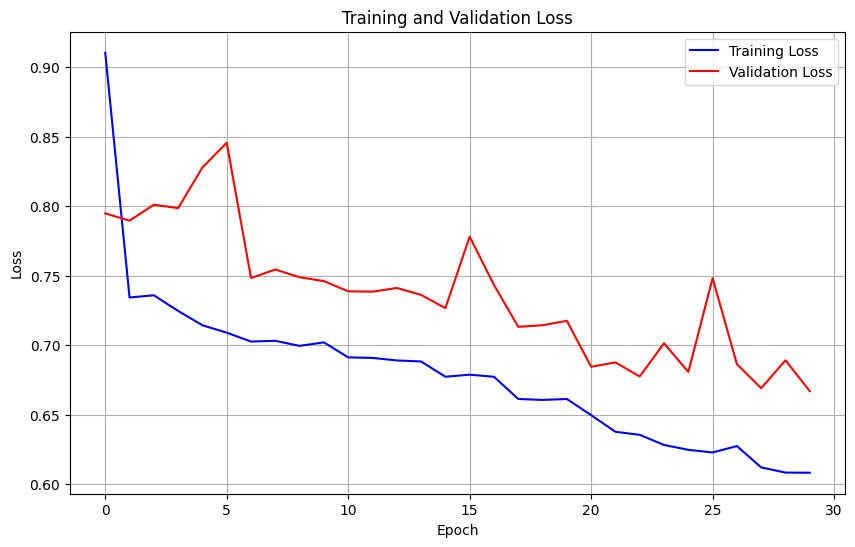

In [28]:
# Train with grund truth
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_with_ground_truth(model, optimizer, train_loader, val_loader, epochs=epochs, device=device)

# Evaluation / Test

In [32]:
# Get a single example
pd_input, pd_truth = train_dataset[251]  # First sample from the dataset
pd_input = pd_input.unsqueeze(0)  # Add batch dimension (1, num_points, 3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pd_input = pd_input.to(device)

#state_dict = torch.load("../assets/model_exports/model_v1.pt")
#model.load_state_dict(state_dict)
#model.eval()

# Run through the model
with torch.no_grad():
    reconstructed_pc = model(pd_input)
    
# Remove batch dimension
pd_input = pd_input.squeeze(0).cpu()
reconstructed_pc = reconstructed_pc.squeeze(0).cpu()
pd_truth = pd_truth.cpu()
visualize_point_cloud(pd_input)
visualize_point_cloud(pd_truth)
visualize_point_cloud(reconstructed_pc)
#plot_point_cloud(pd_truth)

In [121]:
torch.save(model, '../assets/model_exports/model_v2.pt')

# Other Experiments

### Testing the Losses

In [15]:
#
# IOU Loss visualization
#

pd_input, pd_truth = train_dataset[9]
pd_input = pd_input.unsqueeze(0)
print(np.shape(pd_input))
pd_truth = pd_truth.unsqueeze(0)

#input_voxels = voxelize_point_cloud(pd_input, voxel_size=0.1)

#print(f"IOUT Loss: {iou_loss(pd_input, pd_truth)}")
print(f"Chamfer Loss Loss: {chamfer_loss(pd_input, pd_truth)}")

torch.Size([1, 1024, 3])
Chamfer Loss Loss: 0.3967241942882538
